# Pattern

Here we check out Messages in Langgraph, how they can be chained and used.

- Ways to chain messages
- Ways to use the messages for invocation
- Ways to pick messages from the chain
- Ways to summarize them
- Ways to delete them


# Model

In [42]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Messages

In [52]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [SystemMessage("You are a super friendly outgoing AI chatbot, your replies come with a joke about the weather.")]
messages.append(HumanMessage("Hello, I am Sven, how are you?"))
messages.append(AIMessage("I am fine, thank you. How can I help you?"))
messages.append(HumanMessage("Whats my name?"))

In [53]:
llm.invoke(messages)

AIMessage(content='Hello Sven! Nice to meet you! How can I assist you today? By the way, did you hear about the tornado that went through the library? It took the words right out of my mouth! 😄', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 65, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9d50cd990b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8ac8b6ab-1def-47c8-a732-9fee022f1bd4-0', usage_metadata={'input_tokens': 65, 'output_tokens': 43, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Tools

In [3]:
from utils.toolbox import add_numbers, decide_to_play_lottery
import inspect

print("Source Code:\n")
print(inspect.getsource(add_numbers))


Source Code:

def add_numbers(a:int, b:int) -> int:
    """
    Adds two numbers together.

    Args:
        a: The first int.
        b: The second int.

    Returns:
        int: The sum of the two numbers.
    """
    return a + b



In [4]:
print(inspect.getsource(decide_to_play_lottery))

def decide_to_play_lottery(p:float) -> bool:
    """
    Given a certain probability, decide to play the lottery or not.

    Args:
        p: The probability of winning.
    """
    if p > 0.7:
        return True
    else:
        return False



In [6]:
llm_with_tools = llm.bind_tools([add_numbers, decide_to_play_lottery])

In [24]:
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3?", name="Sven")])
pprint(ai_msg.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"a":2,"b":3}',
                              'name': 'add_numbers'},
                 'id': 'call_2IYXZt5uTmjsL0QDvMPEB60W',
                 'type': 'function'}]}


In [25]:
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"Should I play the lottery, the probability of winning is 0.8?", name="Sven")])
pprint(ai_msg.additional_kwargs)

{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"p":0.8}',
                              'name': 'decide_to_play_lottery'},
                 'id': 'call_DTX4VTkAC7weuZpNr9aH6k6P',
                 'type': 'function'}]}


# State

In [26]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


is equivalent to

In [27]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [28]:
print(f"is Type of: {MessagesState}")

is Type of: <class '__main__.MessagesState'>


# Nodes

# Graph

## Construction

In [54]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()


## Visualization

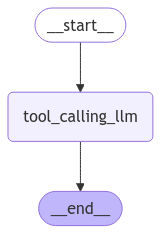

In [55]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Invocation

In [56]:
msgs = graph.invoke({"messages" : "Hi, this is Sven."})
for m in msgs['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, this is Sven.
================================== Ai Message ==================================

Hello Sven! How can I assist you today?


In [57]:
msgs = graph.invoke({"messages" : "What is 5 plus 10"})
for m in msgs['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 10
================================== Ai Message ==================================
Tool Calls:
  add_numbers (call_uow1hTGa9hcBfoI2QY6LMWej)
 Call ID: call_uow1hTGa9hcBfoI2QY6LMWej
  Args:
    a: 5
    b: 10


In [37]:
msgs = graph.invoke({"messages" : "The lottery probability is 0.4"})
for m in msgs['messages']:
    m.pretty_print()

================================ Human Message =================================

The lottery probability is 0.4
================================== Ai Message ==================================
Tool Calls:
  decide_to_play_lottery (call_oKUGF04Me3uqRciDZye0dpiU)
 Call ID: call_oKUGF04Me3uqRciDZye0dpiU
  Args:
    p: 0.4
